In [1]:
from mud.base import *
from mud.funs import wme
from mud.examples import identity_uniform_1D_density_prob

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import distributions as ds

%matplotlib widget

# Simple WME Examples

This notebook intends to cover some simple examples of applying the WME error map to parameter estimation problems involving sequntial observable data. 

TODO: Include note on mud.examples library function Note the examples here are packaed can be accessed , `identity_uniform_1D_density_prob()` problem from the `mud.examples` library will be explores.

## Modifying Observable QoI Map using "Data-Constructed" QoI Maps

Before, assuming a model $M$ we want to fit model paremeters $\lambda$ to, the computational workflow of inputs to output model parameters for parameter estimation becomes:

sample $\lambda$ input parameters $\rightarrow$ compute $M(\lambda)$ $\rightarrow$ density estimation on predicted observables $d \rightarrow$ solve inverse problem

As more data is collected over time, the question is how to incorporate this data to produce a better point estimate of the true parameter. 



Recall in the Bayesian Framework observed data over time was used in the construction of the data-likelihood function.

Along this reasoning, option 1 is to incorporate the collected data into the observed density by using the collected data to set the approximate mean of the observed density.
This doesn't upset the normal workflow from input Paramaters to observables, since we are only using the data collected to affect our observed density and not in any way influencing how we build our predicted density
Remember the predicted dnesity is built using the initial samples from our initial distribution, pushed through our forward model (push-forward of initial == predicted).



The Weighted Mean Error Map offers a different alternative by in contrast fixing the observed distribution at a $N(0,1)$ and incorporating the observed data into the constructino of the very map we are doing inveresion on. The new workflow from model to output parameters becomes then:

sample $\lambda$ input parameters $\rightarrow$ $M(\lambda) \rightarrow q = Q_{WME}(M(\lambda), \mathbf{d})$ for observed data $\mathbf{d} \rightarrow$ density estimation on predicted observables $q \rightarrow$ solve inverse problem

In other words, we are assimilating new data by changing the map from parmaeter to observables that we are performing inversion on by using the weighted mean error map. 

## Steady State Signal

Lets now study the effects of using the WME map for the problem of inferring the value of a stead-state signal.

### Problem Description

Imagine we have a steady-state signal ${d_i}$ coming from a measurement device with i.i.d. gaussian errors.
Then the $i$th data point we collect behaves as:

$\large d_i = y^\dagger + \xi_i, \xi_i \sim N(0,\sigma^2)$

Where $y^\dagger$ is the true stead-state signal value.

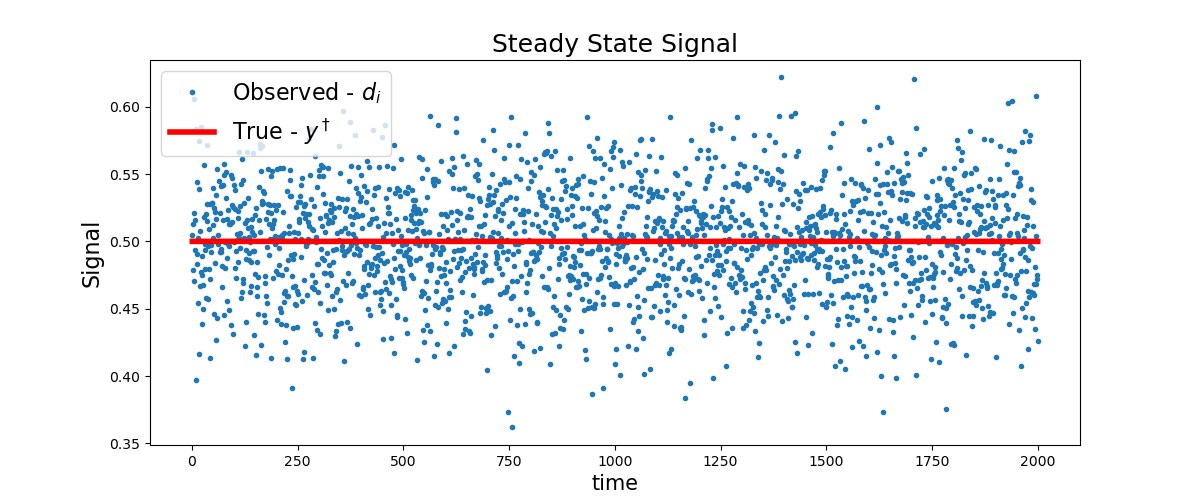

In [2]:
# Problem Definitions
noise = 0.04
num_obs = 2000
y_true = 0.5

# data is truth + noise
y_obs = y_true * np.ones(num_obs) + noise * np.random.randn(num_obs)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(1, num_obs + 1), y_obs, ".", linewidth=4, label="Observed - $d_i$")
ax.plot(
    range(1, num_obs + 1),
    np.repeat(0.5, num_obs),
    "r-",
    linewidth=4,
    label="True - $y^\dagger$",
)
ax.set_ylabel("Signal", fontsize=16)
ax.set_xlabel("time", fontsize=15)
ax.set_title("Steady State Signal", fontsize=18)
ax.legend(fontsize=16, loc="upper left");

Now since the we know the signal is stead-state, we can just use the idenity map as our parameter to model observable map.

Thus we are essentially guessng at the values of the true signal by applying some initial distribution over our model parameter range (which is the same as the range of our signal under the identity map), "pushing" it through our model map, the identiy map, and then using the ratio of it with our observed map to updated on our prior beliefs. 


Lets generate samples from an initital distribution over a range including our true signal and push them through our forward model by collected

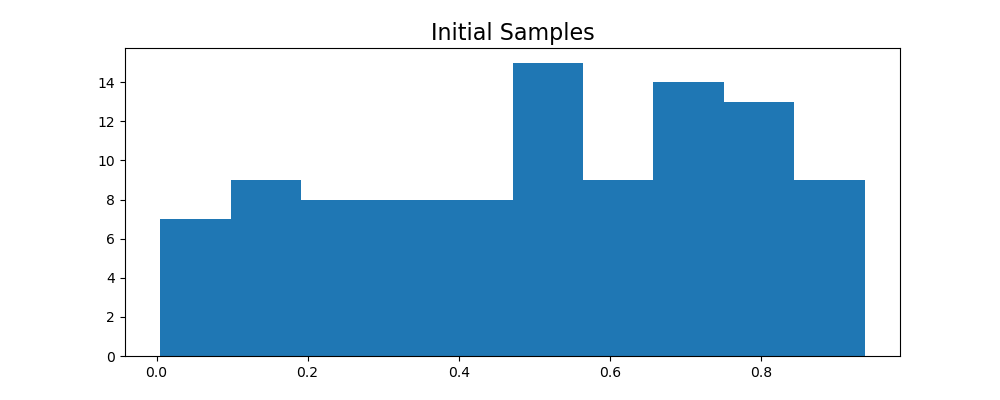

In [3]:
domain = [0, 1]
num_samples = 100

init_dist = ds.uniform(loc=domain[0], scale=domain[1] - domain[0])
X = init_dist.rvs(size=(num_samples, 1))

# Should be rescaled over different intervals, but same distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
_ = ax.hist(X)
_ = ax.set_title("Initial Samples", fontsize=16)

### Incroporating Data Into Observed Distribution

Lets try first incorporating observations ${d_i}$ by using them to estimate the observed distribution mean. 

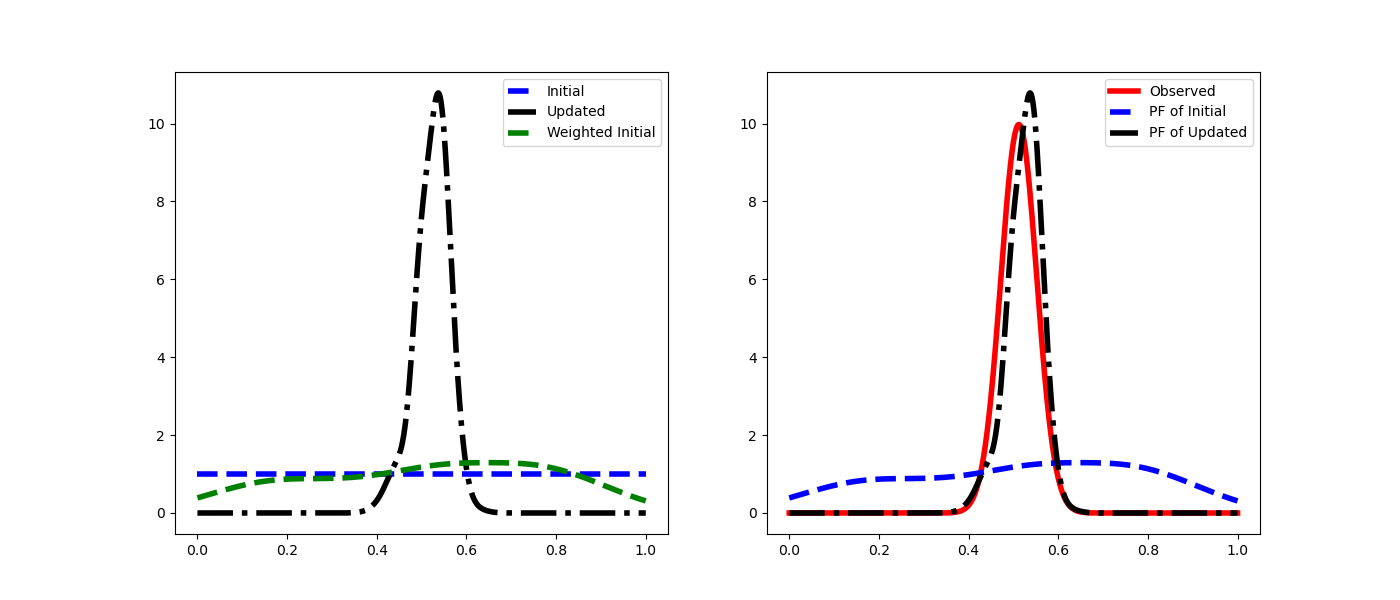

In [12]:
mu_est = np.mean(X)

D1 = DensityProblem(X, X, np.array([domain]))
D1.set_observed(ds.norm(loc=mu_est, scale=noise))
D1.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D1.plot_param_space(ax=ax[0])
D1.plot_obs_space(ax=ax[1], y_range=np.array([domain]))
_ = ax[0].legend()
_ = ax[1].legend()

Note how the predicted density (PF of Initial) looks approximately uniform. 
In fact we know it should be uniform since we have an identity map transforming our initial uniform distribution. 
So we could set it analyticall with the `set_predicted()` method and avoid the rounding errors associated with doing a kernel density estimation on the values of our initial samples pushed through the model (which doesn't do anything to them in this case) to construct the predicted distribution. 

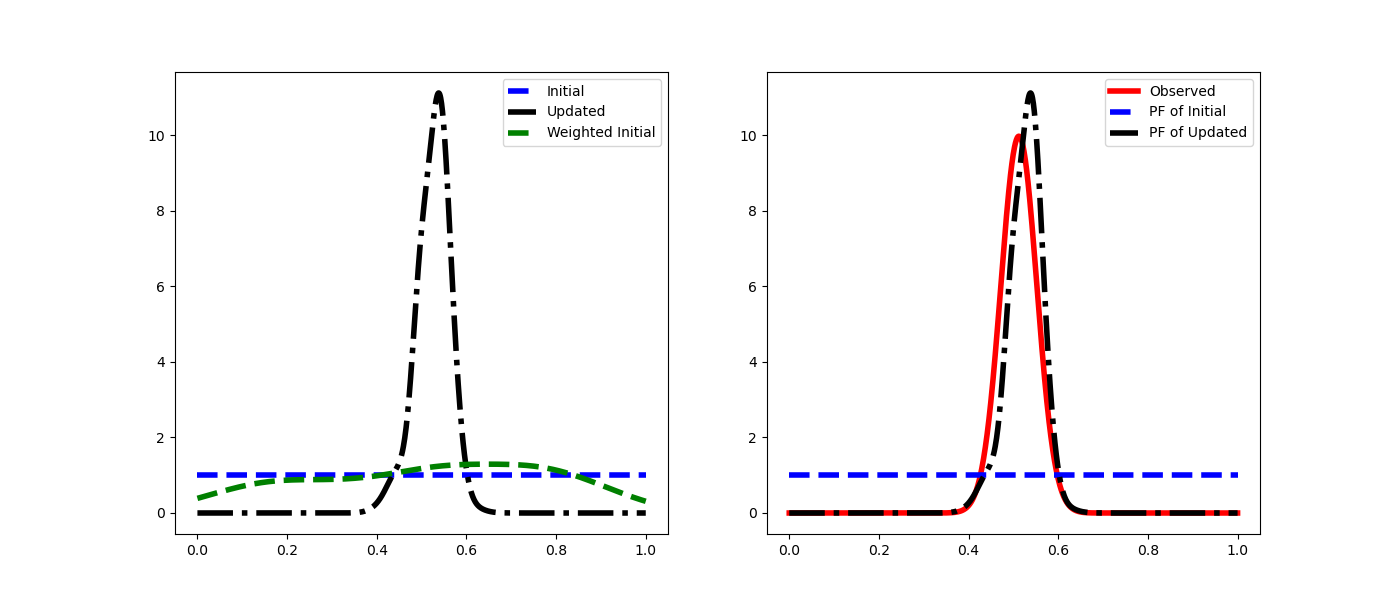

In [13]:
D2 = DensityProblem(X, X, np.array([domain]))
D2.set_observed(ds.norm(loc=mu_est, scale=noise))
D2.set_initial(init_dist)
D2.set_predicted(init_dist)
D2.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D2.plot_param_space(ax=ax[0])
D2.plot_obs_space(ax=ax[1], y_range=np.array([domain]))
_ = ax[0].legend()
_ = ax[1].legend()

Analytically, we know that our updated, observed, and push-forward of observed should all be the same distribution for the problem as it has been set-up. 

### Incorporating Data into Q Map - Weighted Mean Error

Recall the weighted mean error map is given by:

$ \Large Q_{WME}(\lambda) := \frac{1}{\sqrt{N}}\sum_{i=1}^{N}\frac{M(\lambda) - d_i}{\sigma}$

For our single measurement device with a steady signal, we can use our model, the identity map, to draw $N$ observations for each one of our samples from the initial distribution to get a set of predicted measurements over time. 
Note that since our map has no dependence on time, this equates to just repeating each initial sample $N$ times. 
However these $N$ samples will then be used to build the $Q_WME$ map, so our parameter to observable map is just the $Q_WME$ map itself. 

The MUD library provides a `wme()` function under `mud.funs` that computes this quantity using a set of predicted observations, which is a 2 dimensional array, With the each containing the set of predicted observations over time ${Q(\lambda)_i}$. Note that 

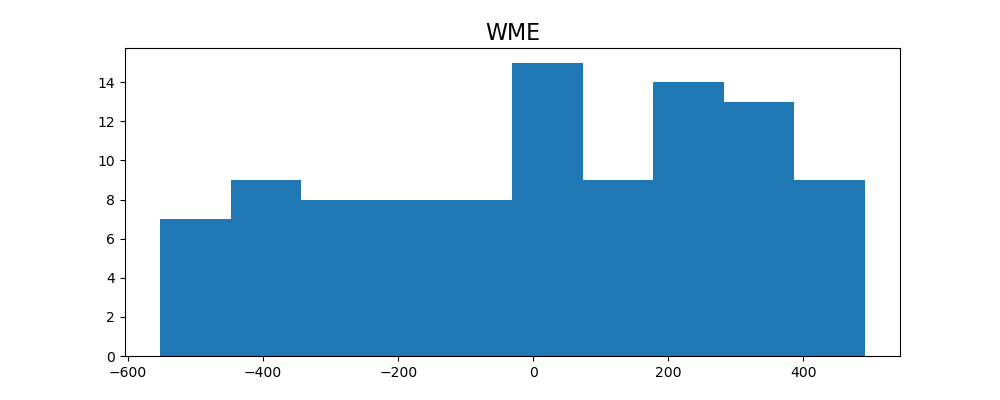

In [14]:
# Repeate measurements from our initial samples to generate predicted signal
y_pred = np.repeat(X, num_obs, 1)

# WME map
Y = wme(y_pred, y_obs, sd=noise)

# Should be rescaled over different intervals, but same distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
_ = ax.hist(Y)
_ = ax.set_title("WME", fontsize=16)

Observe how the WME map simply rescales the uniform initial distribution. How it is rescaled dpeends on the number of observations

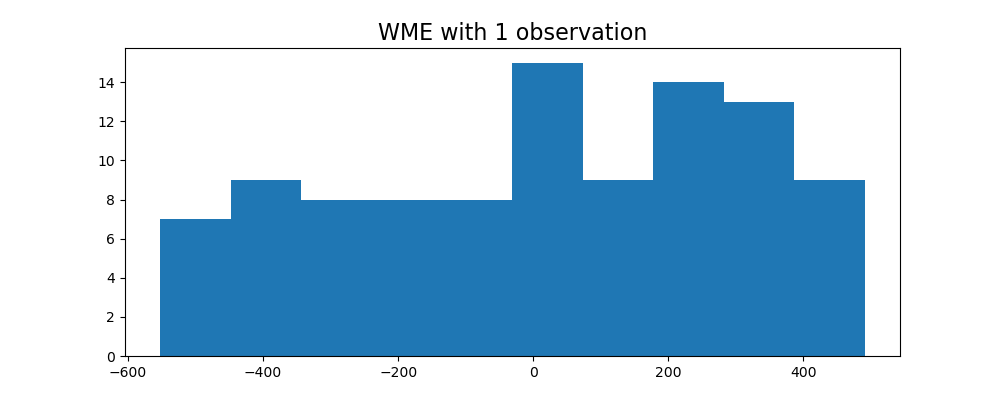

In [15]:
# Build WME map with only 1 observation
Y_1_obs = wme(
    np.repeat(X, 1, 1), y_true * np.ones(1) + noise * np.random.randn(1), sd=noise
)

# Should be rescaled over different intervals, but same distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
_ = ax.hist(Y)
_ = ax.set_title("WME with 1 observation", fontsize=16)

Note how in the case of the identity map, the weighted mean error map does nothing but scale the uniform distribution to a new range depending on the number of observations accumulated.

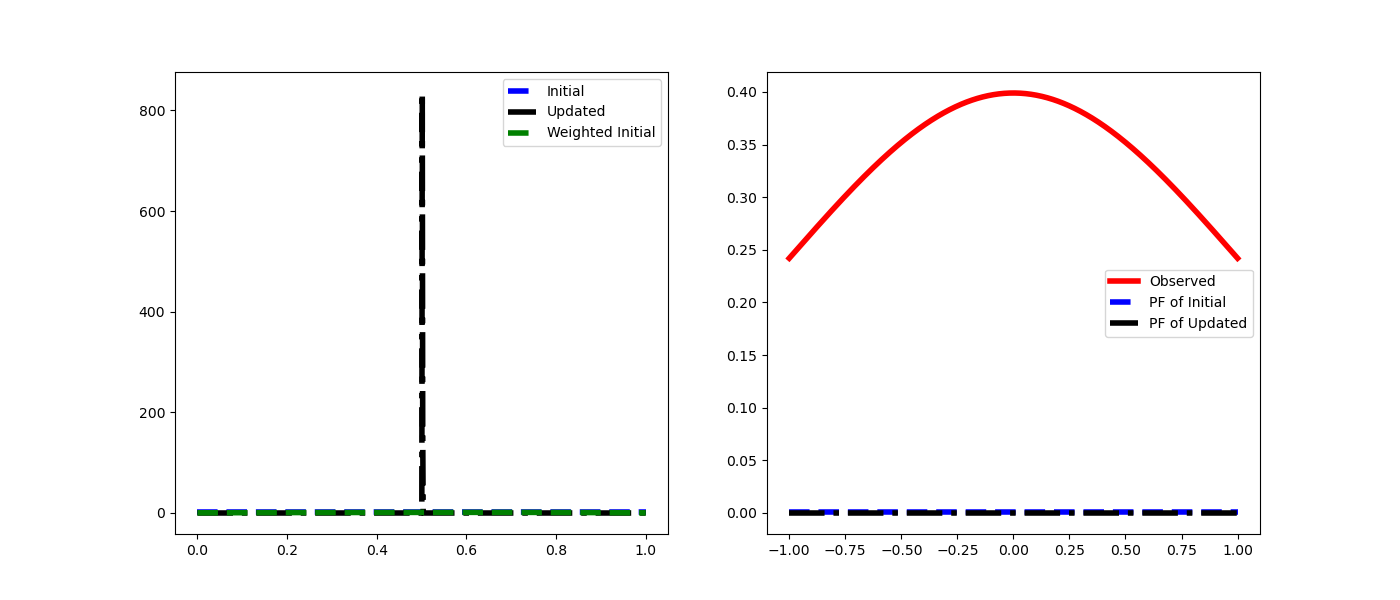

In [16]:
D_WME = DensityProblem(X, Y, np.array([domain]))
D_WME.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D_WME.plot_param_space(ax=ax[0])
D_WME.plot_obs_space(ax=ax[1], y_range=np.array([[-1, 1]]))
_ = ax[0].legend()
_ = ax[1].legend()

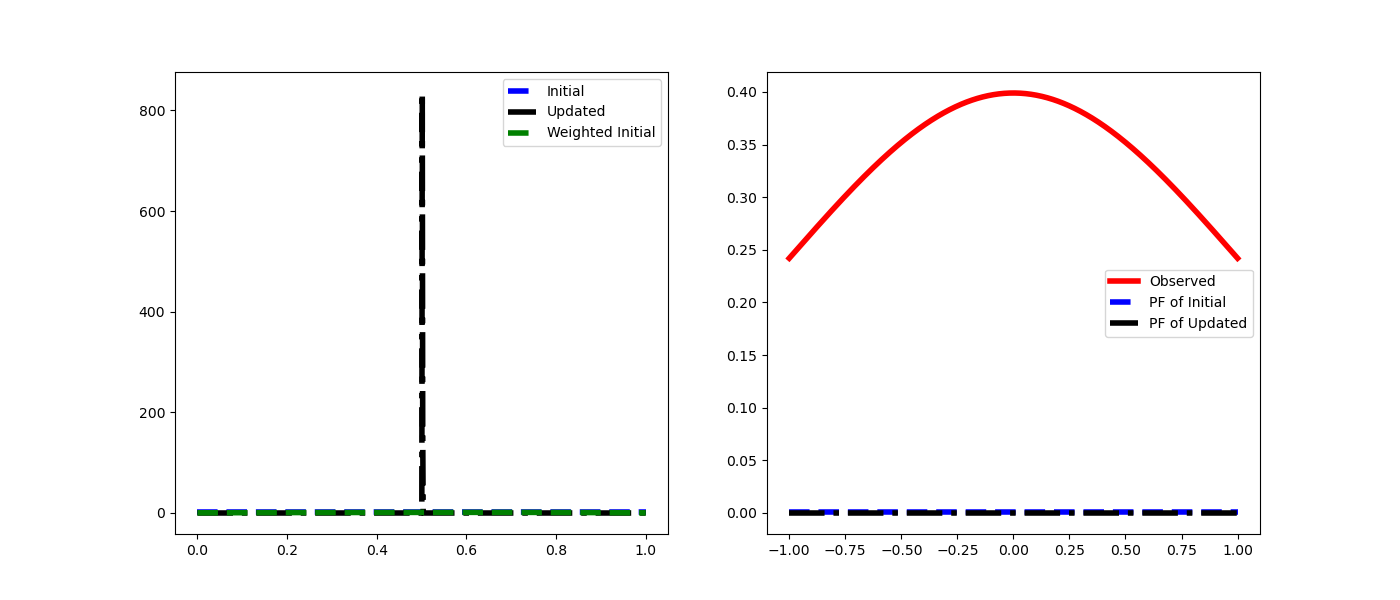

In [17]:
# analytical construction of predicted domain under identity map.
y_domain = np.repeat(np.array([[domain[0]], [domain[1]]]), num_obs, 1)
mn, mx = wme(y_domain, y_obs, sd=noise)
loc, scale = mn, mx - mn

D_WME.set_predicted(ds.uniform(loc=loc, scale=scale))
D_WME.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D_WME.plot_param_space(ax=ax[0])
D_WME.plot_obs_space(ax=ax[1], y_range=np.array([[-1, 1]]))
_ = ax[0].legend()
_ = ax[1].legend()

###

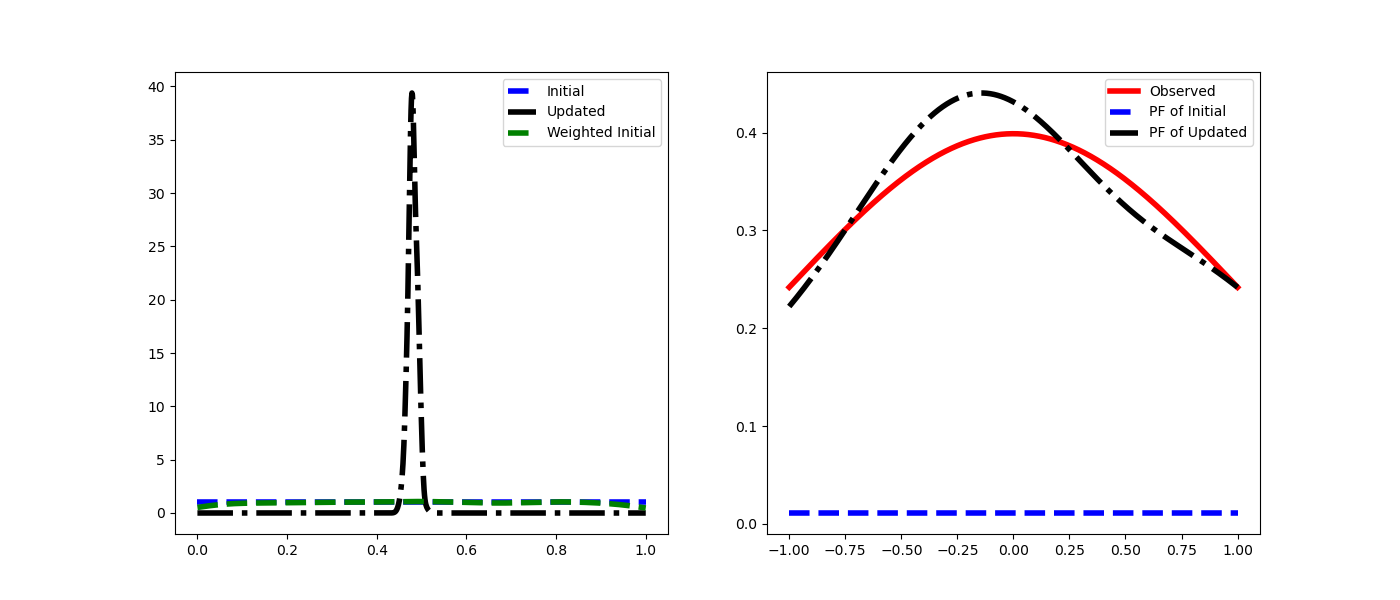

In [18]:
D_WME_1 = identity_uniform_1D_density_prob(num_samples=2000)
D_WME_1.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D_WME_1.plot_param_space(ax=ax[0])
D_WME_1.plot_obs_space(ax=ax[1], y_range=np.array([[-1, 1]]))
_ = ax[0].legend()
_ = ax[1].legend()

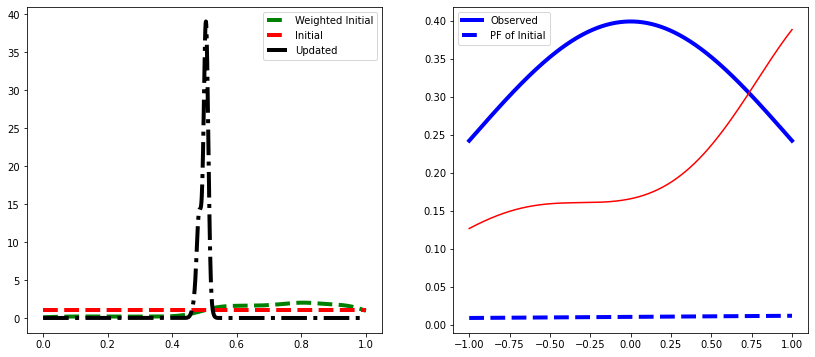

In [4]:
D = identity_uniform_1D_density_prob(num_samples=2000)
weights = np.ones(2000)

# Get indices of samples where the value is in a certain range
weights[D.X[:, 0] < 0.5] = 0.1
D.set_weights(weights)
D.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D.plot_param_space(ax=ax[0], in_opts={"color": "r"})
D.plot_obs_space(
    ax=ax[1],
    ob_opts={"color": "b"},
    pf_opts={"color": "r"},
    y_range=np.array([[-1, 1]]),
)
_ = ax[0].legend()
_ = ax[1].legend()

In [12]:
D.exp_r()

1.1302257687127186

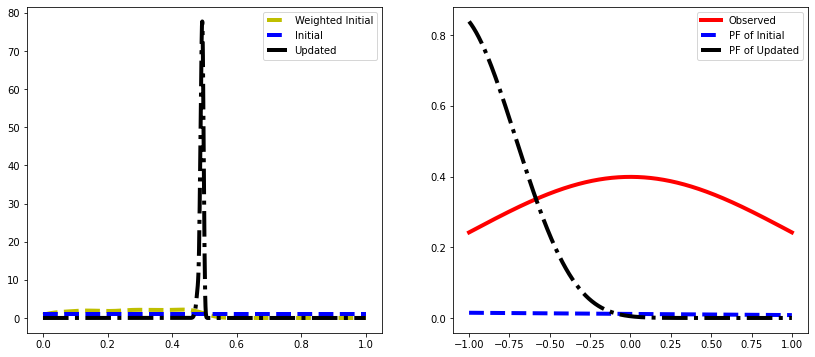

In [13]:
D = identity_uniform_1D_density_prob(num_samples=2000)
weights = np.ones(2000)

# Get indices of samples where the value is in a certain range
weights[D.X[:, 0] < 0.5] = 20
weights[D.X[:, 0] > 0.5] = 0.00
D.set_weights(weights)
D.fit()

# Plot distributions over parameter and observable spaces
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
D.plot_param_space(ax=ax[0], win_opts={"color": "y"})
D.plot_obs_space(ax=ax[1], y_range=np.array([[-1, 1]]))
_ = ax[0].legend()
_ = ax[1].legend()

In [14]:
self._in_dist.pdf(linspace(0, 1, 100)) * np.ones()

NameError: name 'self' is not defined

In [8]:
D = identity_uniform_1D_density_prob(num_samples=2, num_obs=2)
D.fit()
D._weights

array([1., 1.])

In [36]:
D = identity_uniform_1D_density_prob(num_samples=100, num_obs=2)
D.estimate()

array([0.56156894])

In [40]:
import scipy

D = identity_uniform_1D_density_prob(num_samples=100, num_obs=2)
D.set_initial(scipy.stats.norm(0.5, 0.1))
D.exp_r()

1.118008777039795

In [6]:
D._weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [47]:
D = identity_uniform_1D_density_prob()
D.estimate()

array([0.50985057])

In [48]:
D.set_initial(scipy.stats.uniform(0, 1))
D.estimate()

array([0.50985057])

# Influence of using Analytical Predicted Distribution

In this case we can determine the analytical predicted density... whats the error from using KDE to estimate?

In [23]:
D1 = identity_uniform_1D_density_prob(wme_map=False, analytical_pred=False)
D2 = identity_uniform_1D_density_prob(wme_map=False, analytical_pred=True)
D1.estimate(), D2.estimate()

(array([0.00045636]), array([0.0003137]))

In [24]:
D1.exp_r(), D2.exp_r()

(0.366450339036307, 0.34088320213808926)

# Plot Diffs

Calculating avg distance between plotted points between two lines from plot axis object

In [19]:
D = identity_uniform_1D_density_prob()
D.estimate()

array([0.49483815])

3

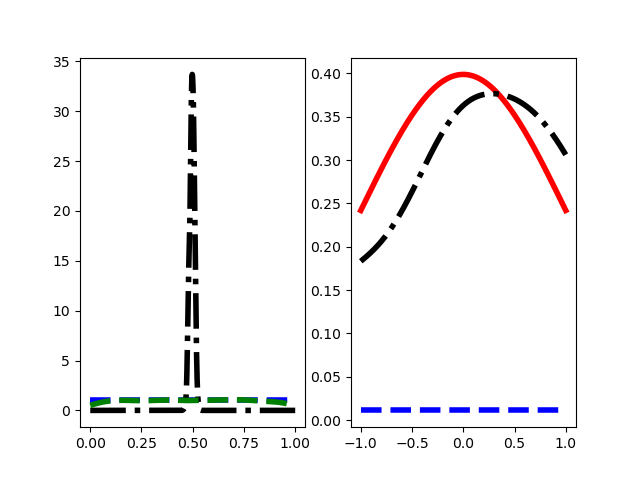

In [20]:
fig, ax = plt.subplots(1, 2)
D.plot_param_space(ax=ax[0])
D.plot_obs_space(ax=ax[1])
len(ax[1].lines)

In [21]:
get_max = lambda x: ax[0].lines[x].get_xdata()[np.argmax(ax[0].lines[x].get_ydata())]

[get_max(x) for x in range(3)]

[0.0, 0.4974974974974975, 0.7037037037037037]

In [22]:
get_diff = lambda x, y: np.average(
    np.abs(ax[1].lines[x].get_ydata() - ax[1].lines[y].get_ydata())
)
get_diff(2, 0)

0.05163126910388347